In [2]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Vocab

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Utility func to compare grads

In [7]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
    


In [8]:
n_embed = 10 #dim of the char embeddings
n_hidden = 64 #num of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)

#Layer1
W1 = torch.randn((block_size*n_embed, n_hidden), generator=g) * (5/3)/((n_embed*block_size)**0.5) #kaining init
b1 = torch.randn(n_hidden, generator=g) * 0.1 #bias is optional here since we use batchnorm after this which cancels out bias term

#Layer2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

#BatchNorm Params
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))* 0.1


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


4137


In [9]:
batch_size = 32
n = batch_size

#construct a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [10]:
#forward pass, split into small steps

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

#Linear Layer 1
h_pre_bn = embcat @ W1 + b1 #hidden layer preact

#Batchnorm layer
bnmeani = 1/n * h_pre_bn.sum(0, keepdim=True)
bndiff = h_pre_bn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) #Bessel's correctn, div by n-1 not n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
h_pre_act = bngain * bnraw + bnbias

#Non linearity
h = torch.tanh(h_pre_act) #hidden layer

#Linear Layer 2
logits = h @ W2 + b2 #output layer

#cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes #subs max for stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 #if 1/counts_sum is used, backprop wont be exact
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#Pytorch backward pass
for p in parameters:
    p.grad = None

for t in [emb, embcat, h_pre_bn, bnmeani, bndiff, bndiff2, bnvar, 
          bnvar_inv, bnraw, h_pre_act, h, logits, logit_maxes, norm_logits, counts, 
          counts_sum, counts_sum_inv, probs, logprobs, loss]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3490, grad_fn=<NegBackward0>)

1. Backpropagate manually

- Cal grads of each of the intermediate variables

In [11]:
#dlogprobs = d(Loss)/dlogprobs

#loss = -(a + b + c)/3 ==> dloss/da = -1/3

#a, b, c in logprobs participate in cal loss for rest grad will be zero

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n # n is the batchsize here, from each batch one prob contributes to loss, as indexed by Yb

#check with pytorch
cmp('logprobs', dlogprobs, logprobs)



logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [12]:
#dprobs = local der * dlogprobs -> 1/x * dlogprobs

dprobs = (1.0/probs) * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


- dprobs will be boosted if probs is low and dlogprobs is non zero, which means cases where correct label has low prob

In [13]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [14]:
dprobs.shape

torch.Size([32, 27])

In [15]:
#count_sum_inv is broadcasted to mul with counts

In [16]:
#dcounts = count_sum_inv * dprobs 
#dcounts_sum_inv = sum(counts * dprobs, 1) : also since this is broadcasted to 27 cols, we sum the grad

dcounts1 = counts_sum_inv * dprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

cmp('counts', dcounts1, counts)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts          | exact: False | approximate: False | maxdiff: 0.005788503214716911
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


- dcounts does not match here since it is being used twice, to cal count_sum also, so grad will flow in from there as well

In [17]:
#dcount_sum = -counts_sum**-2 * dcounts_sum_inv

dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
#2nd part of dcounts = 1 * dcounts_sum, grad dlows equally to all elements of the sum

dcounts2 = 1 * dcounts_sum
dcounts = dcounts1 + dcounts2
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [19]:
#dnorm_logits

dnorm_logits = counts * dcounts
cmp('dnorm_logits', dnorm_logits, norm_logits)

dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
#dlogit_maxes; broadcasting happening here

dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
dlogits1 = dnorm_logits.clone()

cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogits1', dlogits1, logits)



dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits1        | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


In [21]:
dlogit_maxes

tensor([[-2.3283e-09],
        [-3.7253e-09],
        [ 3.7253e-09],
        [ 0.0000e+00],
        [ 2.3283e-09],
        [ 1.1642e-09],
        [ 2.7940e-09],
        [-4.6566e-10],
        [-5.1223e-09],
        [-1.8626e-09],
        [-4.6566e-09],
        [-3.4925e-09],
        [-1.6298e-09],
        [-4.6566e-09],
        [ 4.1910e-09],
        [ 0.0000e+00],
        [-9.3132e-10],
        [ 7.2177e-09],
        [-1.6298e-09],
        [ 4.6566e-10],
        [-4.6566e-10],
        [ 0.0000e+00],
        [-1.6298e-09],
        [-1.3970e-09],
        [ 5.5879e-09],
        [-4.6566e-10],
        [ 5.3551e-09],
        [-4.6566e-10],
        [-6.5193e-09],
        [-9.3132e-10],
        [-1.3970e-09],
        [ 6.5193e-09]], grad_fn=<SumBackward1>)

- dlogit_maxes is very small and it should be since its substracted from logits and it should not impact probs

In [22]:
#dlogits; second part; here grad should be only for max value and rest should be zero

dlogits2 = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dlogits = dlogits1 + dlogits2
cmp('dlogits', dlogits, logits)

dlogits         | exact: True  | approximate: True  | maxdiff: 0.0


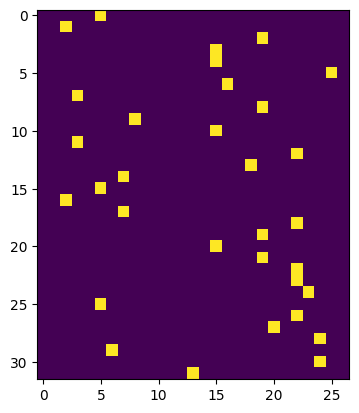

In [23]:
#indices where max value resides is 1, rest is zero
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [24]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [25]:
W2.T.shape

torch.Size([27, 64])

In [26]:
#dh; logits = h@W + b; so dl/dh = dl/dlogits @ W.T; dh will be same dim as h
dh = dlogits @  W2.T
cmp('dh', dh, h)

dh              | exact: True  | approximate: True  | maxdiff: 0.0


In [27]:
#dW2 should be same shape as W2 ie 64, 27; h.T @ dlogits
dW2 = h.T @ dlogits
cmp('dW2', dW2, W2)

dW2             | exact: True  | approximate: True  | maxdiff: 0.0


In [28]:
#db2

db2 = dlogits.sum(0)
cmp('db2', db2, b2)

db2             | exact: True  | approximate: True  | maxdiff: 0.0


In [29]:
#dh_pre_act; backprop through tanh

dh_pre_act = (1.0 - h**2) * dh
cmp('dh_pre_act', dh_pre_act, h_pre_act)


dh_pre_act      | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [30]:
h_pre_act.shape, bngain.shape, bnraw.shape, bnbias.shape, 

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [31]:
#bngain; h_pre_act = bngain * bnraw + bnbias; this is elementwise mul so its simpler

dbngain = (bnraw * dh_pre_act).sum(0, keepdim=True)
cmp('dbngain', dbngain, bngain)


dbngain         | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


In [32]:
dbnraw = (bngain * dh_pre_act)
cmp('dbnraw', dbnraw, bnraw)

dbnraw          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [33]:
dbnbias = dh_pre_act.sum(0, keepdim=True)
cmp('dbnbias', dbnbias, bnbias)

dbnbias         | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


- Backprop through batch norm layer

In [34]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [35]:
#dbndiff1

dbndiff1 = dbnraw * bnvar_inv
cmp('dbndiff', dbndiff1, bndiff)

dbndiff         | exact: False | approximate: False | maxdiff: 0.0011039187666028738


In [36]:
#dbnvar_inv

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar_inv      | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09


In [37]:
#dbnvar

dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('dbnvar', dbnvar, bnvar)

dbnvar          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [38]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [40]:
#dbndiff2

dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff2        | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-11


In [42]:
# dbndiff

dbndiff_2 = 2*bndiff * dbndiff2
dbndiff = dbndiff1 + dbndiff_2
cmp('dbndiff', dbndiff, bndiff)

dbndiff         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [43]:
bndiff.shape, h_pre_bn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [48]:
#bndiff = h_pre_bn - bnmeani

dh_pre_bn = dbndiff.clone()
cmp('dh_pre_bn', dh_pre_bn, h_pre_bn)
dbnmeani = (-dbndiff).sum(0)
cmp('dbnmeani', dbnmeani, bnmeani)


dh_pre_bn       | exact: False | approximate: False | maxdiff: 0.0010791255626827478
dbnmeani        | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


In [49]:
#dh_pre_bn; second part

dh_pre_bn += (1.0/n)*torch.ones_like(h_pre_bn) * dbnmeani
cmp('dh_pre_bn', dh_pre_bn, h_pre_bn)

dh_pre_bn       | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
